# **Used Car Price Predictor**

In [1]:
import os 
import kaggle
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from zlib import crc32
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

# **Import data from Kaggle**

We are using the "US Used cars dataset" from "https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset/data"

In [2]:
kaggleDataset = "ananaymital/us-used-cars-dataset"
datasetPath = os.path.join("dataset", "Used Cars")

In [3]:
# Check if the dataset folder already exists
if os.path.exists(datasetPath):
    download = input("The dataset may already be downloaded. Do you want to download and replace it? (Y/N): ").strip().upper()
    if download == 'Y':
        kaggle.api.dataset_download_files(kaggleDataset, datasetPath, unzip=True)
        print("Dataset downloaded and unzipped.")
    else:
        print("Skipping download.")
else:
    # Download if the dataset folder doesn't exist
    kaggle.api.dataset_download_files(kaggleDataset, datasetPath, unzip=True)
    print("Dataset downloaded and unzipped.")

Dataset URL: https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset
Dataset downloaded and unzipped.


In [4]:
def loadCarData(datasetPath = datasetPath):
    csvPath = os.path.join(datasetPath, "used_cars_data.csv")
    return pd.read_csv(csvPath, nrows=400000, engine='python', on_bad_lines='skip')

# **Examine quick info about the data structure**

In [5]:
carsFullLoad = loadCarData()
carsFullLoad = carsFullLoad[carsFullLoad["price"] > 0]
carsFullLoad.head()

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,A,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,M,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020


In [6]:
carsFullLoad["make_name"].unique()

array(['Jeep', 'Land Rover', 'Subaru', 'Mazda', 'Alfa Romeo', 'BMW',
       'Hyundai', 'Chevrolet', 'Lexus', 'Cadillac', 'Chrysler', 'Dodge',
       'Mercedes-Benz', 'Nissan', 'Honda', 'Kia', 'Ford', 'Lincoln',
       'Audi', 'Jaguar', 'Volkswagen', 'RAM', 'Porsche', 'Toyota',
       'INFINITI', 'GMC', 'Acura', 'Maserati', 'FIAT', 'Volvo',
       'Mitsubishi', 'Buick', 'Mercury', 'Scion', 'Saab', 'MINI',
       'Ferrari', 'Genesis', 'Saturn', 'Bentley', 'Suzuki', 'Tesla',
       'Fisker', 'Pontiac', 'Lamborghini', 'smart', 'Hummer',
       'Rolls-Royce', 'Lotus', 'Spyker', 'McLaren', 'Aston Martin',
       'Kaiser', 'Oldsmobile', 'Maybach', 'Freightliner', 'Karma',
       'Isuzu', 'Plymouth', 'Shelby', 'Triumph', 'MG', 'Pagani', 'Datsun',
       'Studebaker', 'AM General', 'Austin-Healey', 'AMC', 'Hudson',
       'Willys'], dtype=object)

To avoid outliers and keep the project more simple, let's only limit the makes of the car to below, which are common US car makes.

In [7]:
make_names = [
    "Jeep", "Chevrolet", "Cadillac", "Chrysler", "Dodge", "Ford", 
    "Lincoln", "RAM", "GMC", "Buick", "Tesla", "Hummer"
]

carsLoad = carsFullLoad[carsFullLoad["make_name"].isin(make_names)]

In [8]:
carsLoad["make_name"].unique()

array(['Jeep', 'Chevrolet', 'Cadillac', 'Chrysler', 'Dodge', 'Ford',
       'Lincoln', 'RAM', 'GMC', 'Buick', 'Tesla', 'Hummer'], dtype=object)

# **Initial information of our dataset**

In [9]:
carsLoad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185479 entries, 0 to 399997
Data columns (total 66 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   vin                      185479 non-null  object 
 1   back_legroom             177198 non-null  object 
 2   bed                      2147 non-null    object 
 3   bed_height               40526 non-null   object 
 4   bed_length               40526 non-null   object 
 5   body_type                185200 non-null  object 
 6   cabin                    6319 non-null    object 
 7   city                     185479 non-null  object 
 8   city_fuel_economy        150108 non-null  float64
 9   combine_fuel_economy     0 non-null       float64
 10  daysonmarket             185479 non-null  int64  
 11  dealer_zip               185479 non-null  object 
 12  description              176744 non-null  object 
 13  engine_cylinders         179748 non-null  object 
 14  engine_di

In [10]:
carsLoad.describe()

,city_fuel_economy,combine_fuel_economy,daysonmarket,engine_displacement,highway_fuel_economy,horsepower,is_certified,latitude,listing_id,longitude,mileage,owner_count,price,savings_amount,seller_rating,sp_id,vehicle_damage_category,year
count,150108.000000,0.0,185479.000000,176471.000000,150108.000000,176471.000000,0.0,185479.000000,1.854790e+05,185479.000000,1.759000e+05,87375.000000,1.854790e+05,185479.000000,183147.000000,185455.000000,0.0,185479.000000
mean,20.208350,NaN,86.351317,3258.052598,26.774516,272.608293,NaN,41.580310,2.745826e+08,-77.310391,2.941282e+04,1.479348,3.138161e+04,553.901110,4.263669,225421.276110,NaN,2017.718308
std,7.493477,NaN,119.229958,1494.397263,6.542663,89.037421,NaN,1.580706,9.762050e+06,6.388532,4.443715e+04,0.857365,1.700082e+04,989.728469,0.534769,129696.682299,NaN,4.235466
min,8.000000,NaN,0.000000,1000.000000,11.000000,84.000000,NaN,18.398800,5.663194e+07,-157.902000,0.000000e+00,1.000000,2.990000e+02,0.000000,1.000000,41593.000000,NaN,1915.000000
25%,17.000000,NaN,17.000000,2000.000000,23.000000,180.000000,NaN,40.713500,2.735832e+08,-83.284100,5.000000e+00,1.000000,1.998700e+04,0.000000,4.000000,61395.000000,NaN,2017.000000
50%,19.000000,NaN,40.000000,3200.000000,26.000000,281.000000,NaN,41.748500,2.780400e+08,-74.500400,5.273500e+03,1.000000,2.927000e+04,0.000000,4.333333,276905.000000,NaN,2020.000000
75%,22.000000,NaN,94.000000,3600.000000,29.000000,341.000000,NaN,42.561600,2.801435e+08,-72.540400,4.225825e+04,2.000000,4.096700e+04,796.000000,4.619048,326001.000000,NaN,2020.000000
max,127.000000,NaN,2716.000000,8400.000000,127.000000,808.000000,NaN,61.203100,2.817029e+08,-66.158200,4.290461e+06,15.000000,2.698500e+06,20839.000000,5.000000,440798.000000,NaN,2021.000000


# **Cleaning Our Data**

Let's make our dataset only with the columns that are not filled with many null values, and if it is a bit, we can replace the few null values with "No Input".

We will also convert some obvious numeric objects and dates to float types.

In [11]:
cars = carsLoad.loc[:, ["body_type", "daysonmarket", "engine_displacement", "engine_type", "franchise_dealer", "fuel_type", "horsepower", "is_new", "latitude", "listed_date", "listing_color", "listing_id", "longitude", "make_name", "model_name", "mileage", "price", "savings_amount", "seller_rating", "transmission", "trim_name", "wheel_system", "year"]]

for col in ['body_type', 'engine_type', 'fuel_type', 'transmission', "trim_name", 'wheel_system']:
    cars[col] = cars[col].fillna('No Input').str.lower()


for col in ['front_legroom', 'maximum_seating']:
    cars[col] = carsLoad[col].str.extract(r'(\d+(?:\.\d+)?)').astype(float)
    
cars['listed_dateTEMP'] = pd.to_datetime(carsLoad['listed_date']) 
cars['listed_date'] = cars['listed_dateTEMP'].astype('int64') / 1e9
cars.drop('listed_dateTEMP', axis=1, inplace=True)

In [12]:
cars.head()

,body_type,daysonmarket,engine_displacement,engine_type,franchise_dealer,fuel_type,horsepower,is_new,latitude,listed_date,...,mileage,price,savings_amount,seller_rating,transmission,trim_name,wheel_system,year,front_legroom,maximum_seating
0,suv / crossover,522,1300.0,i4,True,gasoline,177.0,True,18.3988,1.554509e+09,...,7.0,23141.0,0,2.800000,a,latitude fwd,fwd,2019,41.2,5.0
27,suv / crossover,522,1300.0,i4,True,gasoline,177.0,True,18.3988,1.554509e+09,...,20.0,27587.0,0,2.800000,a,latitude 4wd,4wd,2019,41.2,5.0
33,suv / crossover,522,1300.0,i4,True,gasoline,177.0,True,18.3988,1.554509e+09,...,7.0,27587.0,0,2.800000,a,latitude 4wd,4wd,2019,41.2,5.0
38,sedan,55,1500.0,i4,True,gasoline,160.0,False,40.7333,1.594858e+09,...,42394.0,14639.0,1749,3.447761,a,lt fwd,fwd,2018,42.0,5.0
41,suv / crossover,27,3600.0,v6,True,gasoline,310.0,False,40.7333,1.597277e+09,...,36410.0,23723.0,3500,3.447761,a,lt cloth fwd,fwd,2018,41.0,8.0


In [13]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185479 entries, 0 to 399997
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   body_type            185479 non-null  object 
 1   daysonmarket         185479 non-null  int64  
 2   engine_displacement  176471 non-null  float64
 3   engine_type          185479 non-null  object 
 4   franchise_dealer     185479 non-null  bool   
 5   fuel_type            185479 non-null  object 
 6   horsepower           176471 non-null  float64
 7   is_new               185479 non-null  bool   
 8   latitude             185479 non-null  float64
 9   listed_date          185479 non-null  float64
 10  listing_color        185479 non-null  object 
 11  listing_id           185479 non-null  int64  
 12  longitude            185479 non-null  float64
 13  make_name            185479 non-null  object 
 14  model_name           185479 non-null  object 
 15  mileage              1

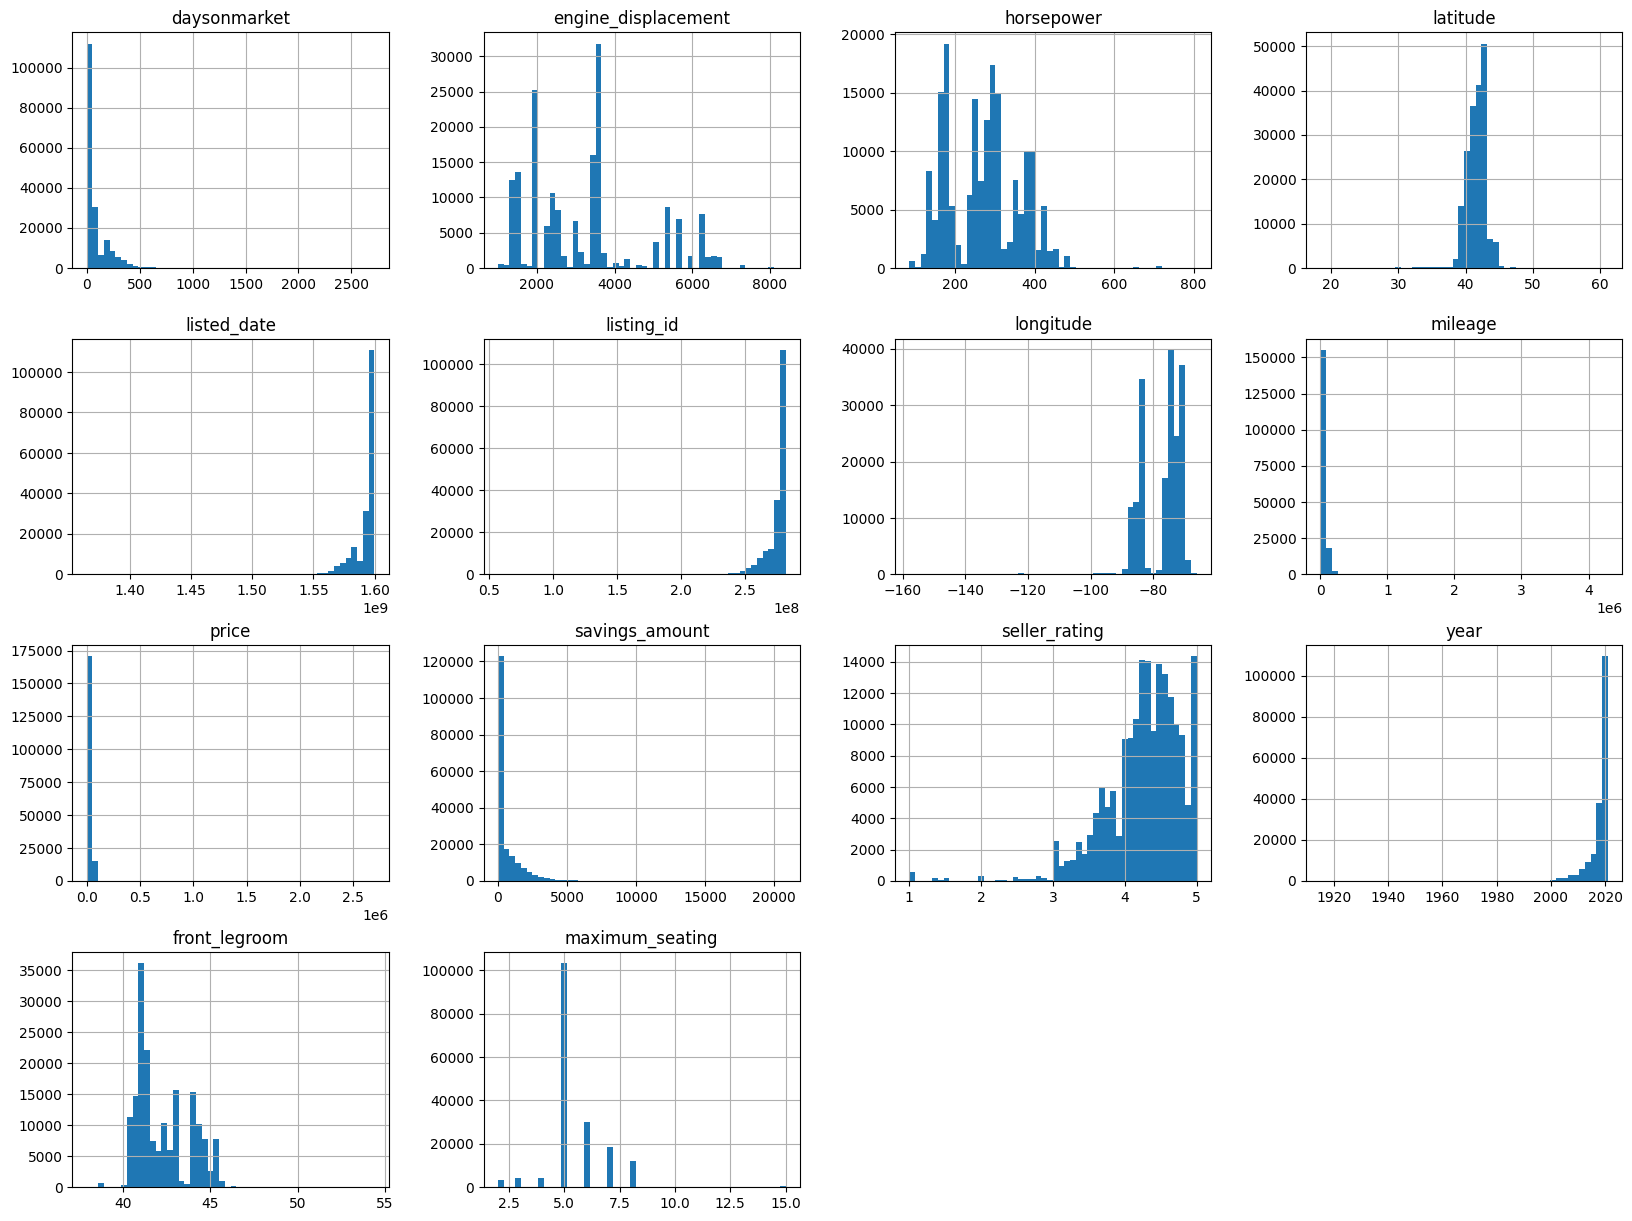

In [14]:
cars.hist(bins=50, figsize=(20,15))
plt.show()

Looking at some of these graphs, we can see some obvious unrealistic values that are skewing the graph. 

Let's find these outliers and filter them out.

In [15]:
max_daysonmarket = cars["daysonmarket"].max()
min_listed_date = cars["listed_date"].min()
min_listing_id = cars["listing_id"].min()
max_mileage = cars["mileage"].max()
max_price = cars["price"].max()
max_savings_amount = cars["savings_amount"].max()
min_year = cars["year"].min()
max_maximum_seating = cars["maximum_seating"].max()

print("Maximum daysonmarket:", max_daysonmarket)
print("Minimum listed_date:", min_listed_date)
print("Minimum listing_id:", min_listing_id)
print("Maximum mileage:", max_mileage)
print("Maximum price:", max_price)
print("Maximum savings_amount:", max_savings_amount)
print("Minimum year:", min_year)
print("Maximum maximum_seating:", max_maximum_seating)

Maximum daysonmarket: 2716
Minimum listed_date: 1364947200.0
Minimum listing_id: 56631937
Maximum mileage: 4290461.0
Maximum price: 2698500.0
Maximum savings_amount: 20839
Minimum year: 1915
Maximum maximum_seating: 15.0


In [16]:
cars = cars[(cars["daysonmarket"] <= 1000) & 
            (cars["listed_date"] >= 1500000000.0) & 
            (cars["listing_id"] >= 200000000) & 
            (cars["mileage"] <= 1000000) &
            (cars["price"] <= 300000) &
            (cars["savings_amount"] <= 20000) & 
            (cars["year"] >= 1990) & 
            (cars["maximum_seating"] <= 11)]

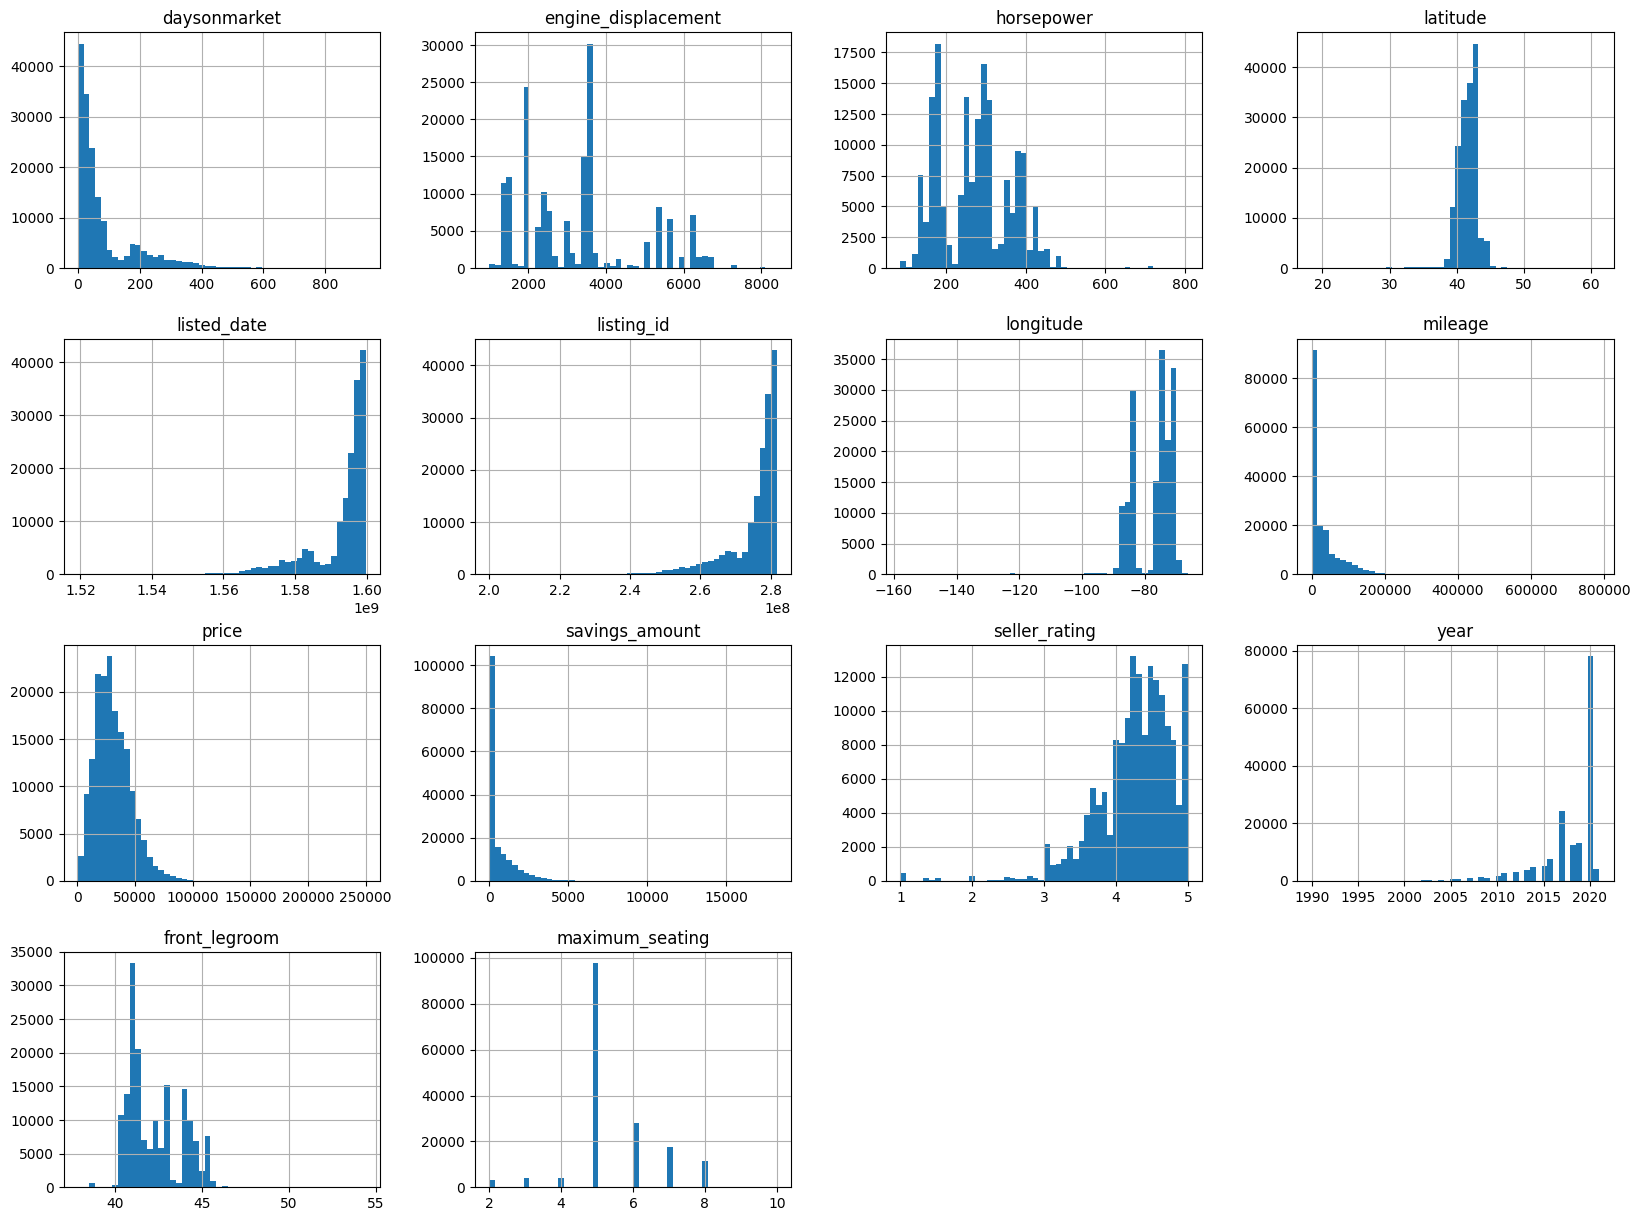

In [17]:
cars.hist(bins=50, figsize=(20,15))
plt.show()

In [18]:
max_daysonmarket = cars["daysonmarket"].max()
min_listed_date = cars["listed_date"].min()
min_listing_id = cars["listing_id"].min()
max_mileage = cars["mileage"].max()
max_price = cars["price"].max()
max_savings_amount = cars["savings_amount"].max()
min_year = cars["year"].min()
max_maximum_seating = cars["maximum_seating"].max()

print("Maximum daysonmarket:", max_daysonmarket)
print("Minimum listed_date:", min_listed_date)
print("Minimum listing_id:", min_listing_id)
print("Maximum mileage:", max_mileage)
print("Maximum price:", max_price)
print("Maximum savings_amount:", max_savings_amount)
print("Minimum year:", min_year)
print("Maximum maximum_seating:", max_maximum_seating)

Maximum daysonmarket: 931
Minimum listed_date: 1519344000.0
Minimum listing_id: 200021460
Maximum mileage: 785778.0
Maximum price: 249999.0
Maximum savings_amount: 18188
Minimum year: 1990
Maximum maximum_seating: 10.0


### Let's make a new column grouping `price`, this will come in handy later to ensure our test set is not running into sampling bias. 

In [19]:
cars["price_group"] = pd.cut(cars["price"],
                            bins=[0., 10000., 20000.,30000., 40000., 50000., np.inf],
                            labels=[1, 2, 3, 4, 5, 6])

<Axes: >

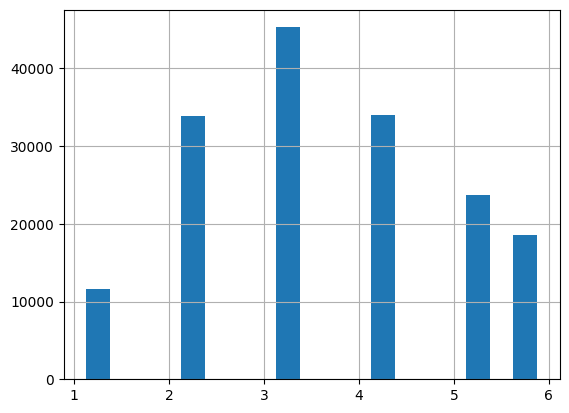

In [20]:
cars["price_group"].hist(rwidth=0.5)

In [21]:
cars["price_group"].value_counts() / len(cars)

price_group
3    0.270940
4    0.203458
2    0.202979
5    0.142225
6    0.111211
1    0.069188
Name: count, dtype: float64

# **Creating our Train and Test Set**

In order to ensure that our test set stays consistent no matter how many times we rerun the program or update the dataset, we want to use a unique identifier to help us decide if the row should go into the test set or not. We can compute a hash for each row's unique identifier and if it is less than or equal to 20% of the maximum hash value, it will go into the test set. 

In [22]:
cars = cars.drop_duplicates(subset="listing_id", keep="first")

In [23]:
len(cars) - len(cars["listing_id"].unique()) # Making sure "listing_id" is unique, this should be zero if true

0

In [24]:
def IDTest(ID, testRatio):
    return crc32(np.int64(ID)) & 0xffffffff < testRatio*2**32

def splitTrainTestByID(dataset,testRatio,ID):
    IDs = dataset[ID]
    testRows = IDs.apply(lambda ID_: IDTest(ID_, testRatio))
    return dataset.loc[~testRows], dataset.loc[testRows]

In [25]:
trainSet, testSet = splitTrainTestByID(cars, 0.2, "listing_id")

In [26]:
len(trainSet) / len(cars) # training set should be 80%

0.7983442281445299

In [27]:
len(testSet) / len(cars) # training set should be 20%

0.20165577185547015

Let's compare our test set's price group proportions to the overall price group proportions.

In [28]:
(testSet["price_group"].value_counts() / len(testSet)) - (cars["price_group"].value_counts() / len(cars))


price_group
1   -0.002901
2    0.001165
3    0.001955
4   -0.000234
5   -0.000301
6    0.000316
Name: count, dtype: float64

The proportions of the price groups in our test set are nearly identical to the overall proportions. 
Therefore, it is not necessary to try and do stratified sampling. 

We can now be confident that our test set is a good representation of the overall dataset.
We can remove the priceGroup column. 
We can also remove listing_id as we do not want the model to make predictions with it.

In [94]:
for set_ in (trainSet, testSet):
    set_.drop(columns=["price_group", "listing_id"], inplace=True)

F:\Local\TEMP\Temp\ipykernel_2352\3444060618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop(columns=["price_group", "listing_id"], inplace=True)
F:\Local\TEMP\Temp\ipykernel_2352\3444060618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop(columns=["price_group", "listing_id"], inplace=True)


# **Visualizing Data**
Now we can play with our train set, first let's start with visualizing the data

<Axes: xlabel='longitude', ylabel='latitude'>

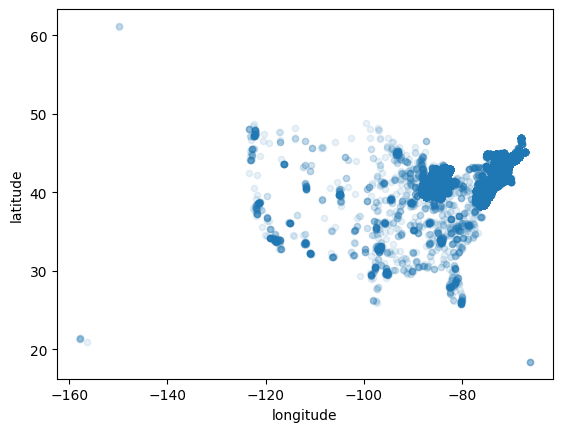

In [30]:
trainSet.plot.scatter(x="longitude", y="latitude", alpha=0.1)

<Axes: xlabel='mileage', ylabel='daysonmarket'>

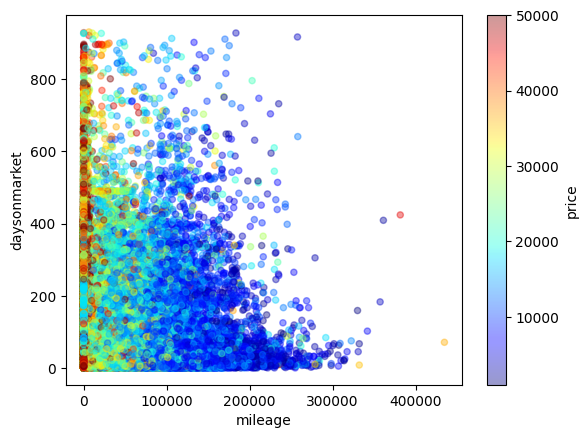

In [31]:
trainSet.plot.scatter(x="mileage", y="daysonmarket", alpha=0.4,
                  c="price", cmap=plt.get_cmap("jet"), colorbar=True,
                  vmin=1000, vmax=50000)

In [32]:
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133365 entries, 0 to 399993
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   body_type            133365 non-null  object  
 1   daysonmarket         133365 non-null  int64   
 2   engine_displacement  132554 non-null  float64 
 3   engine_type          133365 non-null  object  
 4   franchise_dealer     133365 non-null  bool    
 5   fuel_type            133365 non-null  object  
 6   horsepower           132554 non-null  float64 
 7   is_new               133365 non-null  bool    
 8   latitude             133365 non-null  float64 
 9   listed_date          133365 non-null  float64 
 10  listing_color        133365 non-null  object  
 11  listing_id           133365 non-null  int64   
 12  longitude            133365 non-null  float64 
 13  make_name            133365 non-null  object  
 14  model_name           133365 non-null  object  
 15  milea

Let's start looking at correlations and visualize it.

In [33]:
train_numeric_attribs = trainSet.select_dtypes(include=['float64', 'int64'])
corr_matrix = train_numeric_attribs.corr()

In [34]:
corr_matrix["price"].sort_values(ascending=False)

price                  1.000000
horsepower             0.617832
year                   0.578569
engine_displacement    0.402033
front_legroom          0.294748
maximum_seating        0.273038
daysonmarket           0.089151
longitude              0.082384
latitude               0.028781
seller_rating          0.023097
listing_id            -0.083857
listed_date           -0.089771
savings_amount        -0.188785
mileage               -0.586963
Name: price, dtype: float64

array([[<Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='horsepower', ylabel='price'>,
        <Axes: xlabel='year', ylabel='price'>,
        <Axes: xlabel='mileage', ylabel='price'>],
       [<Axes: xlabel='price', ylabel='horsepower'>,
        <Axes: xlabel='horsepower', ylabel='horsepower'>,
        <Axes: xlabel='year', ylabel='horsepower'>,
        <Axes: xlabel='mileage', ylabel='horsepower'>],
       [<Axes: xlabel='price', ylabel='year'>,
        <Axes: xlabel='horsepower', ylabel='year'>,
        <Axes: xlabel='year', ylabel='year'>,
        <Axes: xlabel='mileage', ylabel='year'>],
       [<Axes: xlabel='price', ylabel='mileage'>,
        <Axes: xlabel='horsepower', ylabel='mileage'>,
        <Axes: xlabel='year', ylabel='mileage'>,
        <Axes: xlabel='mileage', ylabel='mileage'>]], dtype=object)

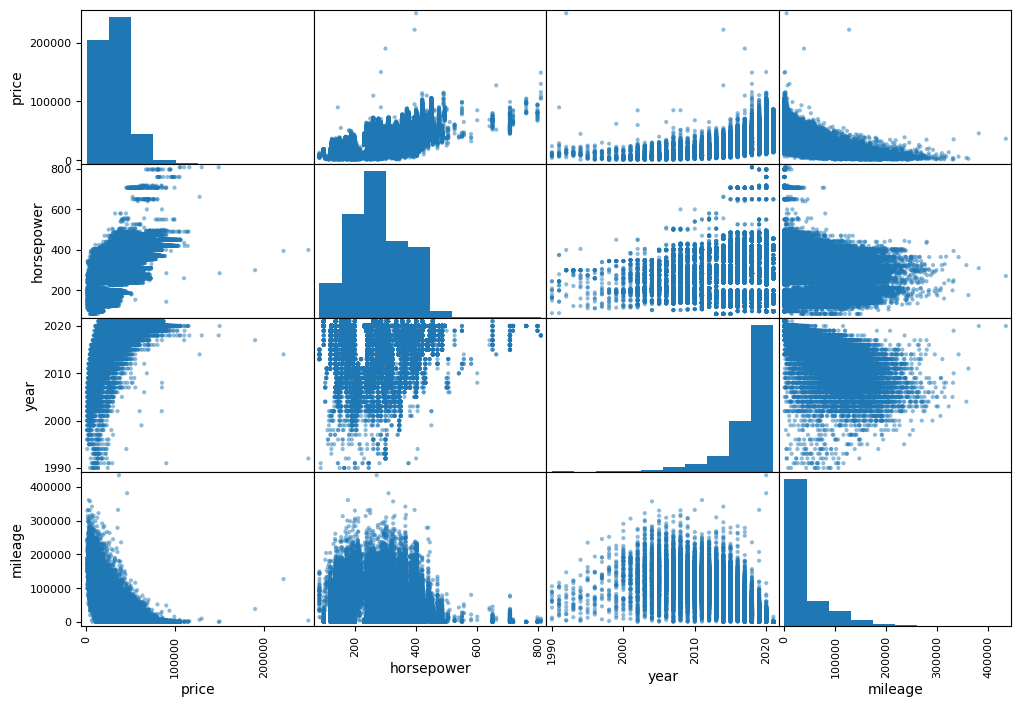

In [35]:
matrix_attributes = ["price", "horsepower", "year", "mileage"]
scatter_matrix(trainSet[matrix_attributes], figsize=(12,8))

# **Data Imputation**

For our transformation pipeline, we will need it to do some data imputation. Some of our float type columns still have some null values. We can replace all null values with the median of the attribute.

To be on the safer side, let's use Scikit-Learn's SimpleImputer class to replace all null values with the median to all numerical columns. Let's see how it will do before creating our pipeline.

In [36]:
X_train = trainSet.drop("price", axis=1)
y_train = trainSet["price"].copy()

In [37]:
X_train_numeric_attribs = X_train.select_dtypes(include=['float64', 'int64'])

imputer = SimpleImputer(strategy="median")
imputer.fit(X_train_numeric_attribs)

SimpleImputer(strategy='median')

In [38]:
imputer.statistics_

array([ 4.00000000e+01,  3.20000000e+03,  2.81000000e+02,  4.17182000e+01,
        1.59615360e+09,  2.78048740e+08, -7.44935000e+01,  6.11900000e+03,
        0.00000000e+00,  4.33333333e+00,  2.01900000e+03,  4.18000000e+01,
        5.00000000e+00])

In [39]:
X_train_numeric_attribs.median().values

array([ 4.00000000e+01,  3.20000000e+03,  2.81000000e+02,  4.17182000e+01,
        1.59615360e+09,  2.78048740e+08, -7.44935000e+01,  6.11900000e+03,
        0.00000000e+00,  4.33333333e+00,  2.01900000e+03,  4.18000000e+01,
        5.00000000e+00])

# **Categorical Data Preprocessing**

In our pipeline, we want to change the bool columns, "is_new" and "franchise_dealer", to a numeric value using OrdinalEncoder. Let's see how it works.

In [40]:
X_train_bool_attribs = X_train.select_dtypes(include=['bool'])
ordinal_encoder = OrdinalEncoder()
X_train_bool_attribs_encoded = ordinal_encoder.fit_transform(X_train_bool_attribs)
X_train_bool_attribs_encoded[:10]

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

For our pipeline, we also want to change the categorical columns to a numeric value. For this we can use OneHotEncoder. Let's see how it is.

In [41]:
X_train_object_attribs = X_train.select_dtypes(include=['object'])
object_encoder = OneHotEncoder()
X_train_object_attribs_1hot = object_encoder.fit_transform(X_train_object_attribs)
X_train_object_attribs_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1200285 stored elements and shape (133365, 2188)>

In [42]:
X_train_object_attribs_1hot.toarray()

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [43]:
object_encoder.categories_

[array(['convertible', 'coupe', 'hatchback', 'minivan', 'no input',
        'pickup truck', 'sedan', 'suv / crossover', 'van', 'wagon'],
       dtype=object),
 array(['i3', 'i4', 'i4 diesel', 'i4 flex fuel vehicle', 'i4 hybrid', 'i5',
        'i5 biodiesel', 'i5 diesel', 'i6', 'i6 diesel', 'no input', 'v10',
        'v6', 'v6 biodiesel', 'v6 diesel', 'v6 flex fuel vehicle',
        'v6 hybrid', 'v8', 'v8 biodiesel', 'v8 compressed natural gas',
        'v8 diesel', 'v8 flex fuel vehicle', 'v8 hybrid'], dtype=object),
 array(['biodiesel', 'compressed natural gas', 'diesel',
        'flex fuel vehicle', 'gasoline', 'hybrid', 'no input'],
       dtype=object),
 array(['BLACK', 'BLUE', 'BROWN', 'GOLD', 'GRAY', 'GREEN', 'ORANGE',
        'PINK', 'PURPLE', 'RED', 'SILVER', 'TEAL', 'UNKNOWN', 'WHITE',
        'YELLOW'], dtype=object),
 array(['Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'Ford',
        'GMC', 'Hummer', 'Jeep', 'Lincoln', 'RAM'], dtype=object),
 array(['1500', '200',

# **Transformation Pipeline**

Now we can start building our transformation pipelines.

Let's make a numerical pipeline first for our numeric columns. We will replace all null values with the median values, and also use StandardScaler() to scale all columns.

In [44]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

X_train_numeric_transformed = numeric_pipeline.fit_transform(X_train_numeric_attribs)

Now we can make our full pipeline, where we use the numeric_pipeline for our numerical columns, Ordinalencoder() for our bool columns, and OneHotEncoder() for our object columns. 

In [45]:
numeric_attribs = list(X_train_numeric_attribs)
bool_attribs = list(X_train_bool_attribs)
object_attribs = list(X_train_object_attribs)

full_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_attribs),
    ('bool', OrdinalEncoder(), bool_attribs),
    ('objects', OneHotEncoder(handle_unknown='ignore'), object_attribs), 
])

In [46]:
X_train_prepared = full_pipeline.fit_transform(X_train)

We now have prepared our training set for training. 

# **Selecting and Training a Model**

# **1) Linear Regression Model**

We will first try to train the model using a Linear Regression Model

In [47]:
train_lin_reg = LinearRegression()
train_lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

We can get a small sample of how it does with some data from the training set itself.

In [48]:
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", train_lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [23808.57105409 25970.10577023 25913.10161968 15954.29591687
 24732.30815498]
Labels: [23141.0, 27587.0, 27587.0, 14639.0, 23723.0]


In [49]:
train_lin_reg_predictions = train_lin_reg.predict(X_train_prepared)

### Let's create functions that will print out our results.

In [50]:
def CalcAndPrintMetrics(predictions, y, model_name="Model"):
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    mape = np.mean(np.abs((y - predictions) / y)) * 100  

    print(f"{model_name} Evaluation Metrics")
    print(f"{model_name} Root Mean Squared Error (RMSE):", rmse)
    print(f"{model_name} Mean Absolute Error (MAE):", mae)
    print(f"{model_name} R² Score:", r2)
    print(f"{model_name} Mean Absolute Percentage Error (MAPE):", mape, "%")

In [51]:
CalcAndPrintMetrics(train_lin_reg_predictions, y_train, "Linear Regression")

Linear Regression Evaluation Metrics
Linear Regression Root Mean Squared Error (RMSE): 3889.2630072519974
Linear Regression Mean Absolute Error (MAE): 2782.813151964835
Linear Regression R² Score: 0.9376653522787568
Linear Regression Mean Absolute Percentage Error (MAPE): 12.274756625426466 %


### Let's use cross-validation to get a better picture of our results.

In [52]:
train_lin_reg_CV_scores = cross_val_score(train_lin_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)

In [53]:
def CalcAndPrintCVScores(cv_scores, model_name="Model"):
    cv_rmse_scores = np.sqrt(-cv_scores)
    
    print(f"\n{model_name} Cross-Validation Metrics")
    print(f"{model_name} Cross-Validation RMSE Scores:", cv_rmse_scores)
    print(f"{model_name} Mean Cross-Validation RMSE:", cv_rmse_scores.mean())
    print(f"{model_name} Cross-Validation RMSE Standard Deviation:", cv_rmse_scores.std())

In [54]:
CalcAndPrintCVScores(train_lin_reg_CV_scores, "Linear Regression")


Linear Regression Cross-Validation Metrics
Linear Regression Cross-Validation RMSE Scores: [3999.45275325 4503.16372079 3846.56237025 3852.39235003 4101.79780803
 3829.24855033 4194.05720143 4182.34243874 4451.61464599 4130.89476393]
Linear Regression Mean Cross-Validation RMSE: 4109.152660276402
Linear Regression Cross-Validation RMSE Standard Deviation: 226.02591950276414


# **2) Decision Tree Regression**

In [55]:
from sklearn.tree import DecisionTreeRegressor

train_tree_reg = DecisionTreeRegressor()
train_tree_reg.fit(X_train_prepared, y_train)

DecisionTreeRegressor()

In [56]:
train_tree_reg_predictions = train_tree_reg.predict(X_train_prepared)

In [57]:
CalcAndPrintMetrics(train_tree_reg_predictions, y_train, "Decision Tree Regression")

Decision Tree Regression Evaluation Metrics
Decision Tree Regression Root Mean Squared Error (RMSE): 3.530265583623406
Decision Tree Regression Mean Absolute Error (MAE): 0.024009297791774454
Decision Tree Regression R² Score: 0.9999999486418181
Decision Tree Regression Mean Absolute Percentage Error (MAPE): 7.399444947054722e-05 %


In [58]:
train_tree_reg_CV_scores = cross_val_score(train_tree_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)

In [59]:
CalcAndPrintCVScores(train_tree_reg_CV_scores, "Decision Tree Regression")


Decision Tree Regression Cross-Validation Metrics
Decision Tree Regression Cross-Validation RMSE Scores: [4352.0580225  4850.199242   3860.3318794  4631.84544682 4310.627328
 4172.09391852 4602.08626597 4780.97375241 4734.62521089 4486.33450945]
Decision Tree Regression Mean Cross-Validation RMSE: 4478.117557595563
Decision Tree Regression Cross-Validation RMSE Standard Deviation: 292.281448083946


# **3) Random Forest Regression**

In [60]:
from sklearn.ensemble import RandomForestRegressor

train_forest_reg = RandomForestRegressor()
train_forest_reg.fit(X_train_prepared, y_train)

RandomForestRegressor()

In [61]:
train_forest_reg_predictions = train_forest_reg.predict(X_train_prepared)

In [62]:
CalcAndPrintMetrics(train_forest_reg_predictions, y_train, "Random Forest Regression")

Random Forest Regression Evaluation Metrics
Random Forest Regression Root Mean Squared Error (RMSE): 972.04744397532
Random Forest Regression Mean Absolute Error (MAE): 562.4265229120225
Random Forest Regression R² Score: 0.9961062343549262
Random Forest Regression Mean Absolute Percentage Error (MAPE): 2.26624333971046 %


In [63]:
train_forest_reg_CV_scores = cross_val_score(train_forest_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)

In [64]:
CalcAndPrintCVScores(train_forest_reg_CV_scores, "Random Forest Regression")


Random Forest Regression Cross-Validation Metrics
Random Forest Regression Cross-Validation RMSE Scores: [3192.28076869 3631.28722719 2909.6725723  3107.01066507 3318.35616477
 3150.61376825 3163.18128235 3388.22147492 3655.43022139 3375.24222618]
Random Forest Regression Mean Cross-Validation RMSE: 3289.1296371109906
Random Forest Regression Cross-Validation RMSE Standard Deviation: 221.56737486564586


#### These metrics gives us an interesting result between the Decision Tree and the Random Forest models. The Decision Tree model first had a RMSE of **69**, while the Random Forest had **966**. This could give us the idea that the Decision Tree model is performing significantly better than the Random Forest model. However, the mean Cross-Validation RMSE results tells us differently. The Decision Tree model had a mean Cross-Validation RMSE of **4,399**, while the Random Forest had **3,281**.

#### This discrepancy suggests that the Decision Tree model may be **overfitting** to the training data, as it achieves a very low RMSE on the complete training set but performs worse during cross-validation. The Random Forest model, while having a higher initial RMSE on the complete training data, shows more stable and reliable performance across folds in cross-validation.

#### In summary, the Random Forest model’s lower mean Cross-Validation RMSE indicates it generalizes better to new data and is likely the more robust model overall more than the Decision Tree model. This highlights the importance of cross-validation in evaluating a model’s performance and avoiding misleading conclusions from training results alone.

# **Fine Tuning Random Forest Using RandomizedSearchCV**

Let's do some hyperparameter tuning on the RandomForestRegressor using RandomizedSearchCV.

In [65]:
param_grid = [
    {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt'],  # Number of features considered for each split
    'bootstrap': [True, False]  # Whether samples are drawn with replacement
    }
]

train_forest_reg_tuned = RandomForestRegressor()

Randomized_search = RandomizedSearchCV(train_forest_reg_tuned, param_grid, n_iter=100, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           refit=True,
                           return_train_score=True)

Randomized_search.fit(X_train_prepared, y_train)

c:\Users\maxim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
164 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\maxim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\maxim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\maxim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': [None, 10, 20, 30, 40,
                                                       50],
                                         'max_features': ['auto', 'sqrt'],
                                         'min_samples_leaf': [1, 2, 4],
                                         'min_samples_split': [2, 5, 10],
                                         'n_estimators': [100, 200, 300, 400,
                                                          500]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

Let's view what was the best hperparameters and estimators in our RandomizedSearchCV

In [66]:
Randomized_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [67]:
Randomized_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=300)

Let's view the RMSE for each tested parameter set, and we should see `{'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}` being the lowest.

In [68]:
cvres = Randomized_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

nan {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}
nan {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}
4993.713167783689 {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
nan {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
5817.386679681885 {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
nan {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
4943.9251645867025 {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
5407.452994487214 

Let's get the feature importances from our best model found, and after creating our complete feature list, we can sort and display feature importances from most to least influential

In [69]:
feature_importances = Randomized_search.best_estimator_.feature_importances_
feature_importances

array([0.0098077 , 0.04623399, 0.09180176, ..., 0.02466919, 0.00019439,
       0.0015903 ])

In [70]:
object_encoder = full_pipeline.named_transformers_["objects"]
object_one_hot_attribs = np.concatenate(object_encoder.categories_)
object_attribs = list(object_one_hot_attribs)
attributes = numeric_attribs + bool_attribs + object_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.09180176230214872), 'horsepower'),
 (np.float64(0.08955864480154846), 'mileage'),
 (np.float64(0.08432896983170103), 'year'),
 (np.float64(0.05721409803569621), 'is_new'),
 (np.float64(0.05635783666605337), 'savings_amount'),
 (np.float64(0.04880060014958488), 'front_legroom'),
 (np.float64(0.04623399167048033), 'engine_displacement'),
 (np.float64(0.03169176628224), 'franchise_dealer'),
 (np.float64(0.03038927896832109), 'maximum_seating'),
 (np.float64(0.02755130862905372), '4wd'),
 (np.float64(0.02466918954646045), 'fwd'),
 (np.float64(0.01877124398361294), 'i4'),
 (np.float64(0.015654292275351808), 'v8'),
 (np.float64(0.014711878230074662), 'pickup truck'),
 (np.float64(0.010673500165776117), 'listing_id'),
 (np.float64(0.010295375348890303), 'sedan'),
 (np.float64(0.010138837032312591), 'listed_date'),
 (np.float64(0.010096172390810006), 'longitude'),
 (np.float64(0.009807703217019827), 'daysonmarket'),
 (np.float64(0.00920938947626517), 'latitude'),
 (np.float64(0.

### We can see that the most influential feature in our best model is the `year` column, followed by `horsepower`, and so on.

# **Testing Our Model**

Let's make the fine-tuned Random Forest by RandomizedSearchCV model as our final model for testing and print the RMSE

In [71]:
X_test = testSet.drop("price", axis = 1)
y_test = testSet["price"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [72]:
final_model = Randomized_search.best_estimator_

final_model_predictions = final_model.predict(X_test_prepared)

In [73]:
CalcAndPrintMetrics(final_model_predictions, y_test, "Final Model (Fined Tuned Random Forest by RandomizedSearchCV)")

Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Evaluation Metrics
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Root Mean Squared Error (RMSE): 2766.4124483909372
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Absolute Error (MAE): 1849.1594765227603
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) R² Score: 0.9678870609072174
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Absolute Percentage Error (MAPE): 8.078046079023672 %


In [74]:
final_model_CV_scores = cross_val_score(final_model, X_test_prepared, y_test, scoring="neg_mean_squared_error", cv=10)

In [75]:
CalcAndPrintCVScores(final_model_CV_scores, "Final Model (Fined Tuned Random Forest by RandomizedSearchCV)")


Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Cross-Validation Metrics
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Cross-Validation RMSE Scores: [3754.00258055 3740.36589566 3541.01710643 3721.52117545 4093.45254945
 3662.82076906 3592.3529315  3682.22072494 3733.88971262 3764.75996897]
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Cross-Validation RMSE: 3728.6403414631686
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Cross-Validation RMSE Standard Deviation: 139.82677788883285


Let's get the squared errors of each prediction, so we can better understand the RMSE by getting a 95% confidence interval and 10 samples.

In [76]:
final_model_squared_errors = (final_model_predictions - y_test) ** 2

print("Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Squared Error:", final_model_squared_errors.mean())
print("Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Standard Error of Mean:", stats.sem(final_model_squared_errors))

Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Squared Error: 7653037.834612339
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Standard Error of Mean: 215023.62939327222


In [77]:
df_final_model_squared_errors = pd.DataFrame({'Predictions': final_model_predictions, 'Actual': y_test, 'Squared Errors': final_model_squared_errors})
print(df_final_model_squared_errors.head(10)) 

      Predictions   Actual  Squared Errors
81   35129.316667  34224.0    8.195983e+05
85   26775.326667  23300.0    1.207790e+07
91   15730.110000  12924.0    7.874253e+06
96   21300.323333  18959.0    5.481795e+06
98   55232.140000  57000.0    3.125329e+06
133  16574.700000  15724.0    7.236905e+05
141  27593.706667  27200.0    1.550049e+05
148  28119.486667  27300.0    6.715584e+05
173  35394.606667  32439.0    8.735611e+06
185  27333.670000  25272.0    4.250483e+06


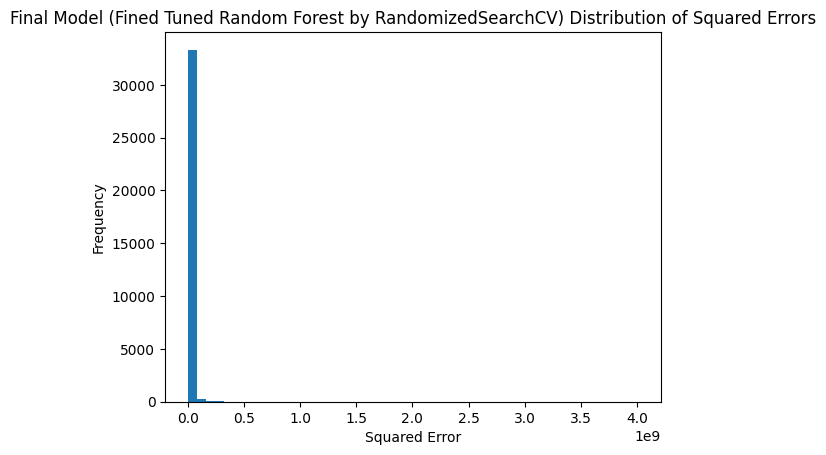

In [78]:
plt.hist(final_model_squared_errors, bins=50)
plt.title('Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Distribution of Squared Errors')
plt.xlabel('Squared Error')
plt.ylabel('Frequency')
plt.show()

Let's view our biggest errors by getting our top 1% outliers of our squared errors.

In [79]:
outliers = df_final_model_squared_errors[df_final_model_squared_errors['Squared Errors'] > df_final_model_squared_errors['Squared Errors'].quantile(0.99)] 
print(outliers)

         Predictions   Actual  Squared Errors
735     24035.973333  14475.0    9.141221e+07
3987    71206.183333  60187.0    1.214224e+08
4016    71020.540000  60187.0    1.173656e+08
4435    69621.353333  79860.0    1.048299e+08
6780    20545.000000  31540.0    1.208900e+08
...              ...      ...             ...
394296  42463.360000  52180.0    9.441309e+07
395754  71633.066667  84794.0    1.732102e+08
396483  42475.666667  55475.0    1.689827e+08
396597  66143.076667  76095.0    9.904078e+07
398238  27211.623333  15990.0    1.259248e+08

[337 rows x 3 columns]


Let's view the 95% confidence interval of our RMSE

In [80]:
confidence = 0.95

np.sqrt(stats.t.interval(confidence, len(final_model_squared_errors)-1,
                         loc=final_model_squared_errors.mean(),
                         scale=stats.sem(final_model_squared_errors)))


array([2689.16048648, 2841.56498205])

# **Saving Our Final Model Using joblib**

We want to save our final model, but also save our original columns that we use in the model, our transformation pipeline, and a sample of the data we used to train. 

In [ ]:
import joblib

# Summary of our columns
column_summary = {}

for col in X_train.columns:
    col_data = X_train[col]  
    
    if pd.api.types.is_numeric_dtype(col_data):  
        column_summary[col] = {
            "dtype": col_data.dtype,
            "min": col_data.min(),
            "max": col_data.max(),
        }
    
    else: 
        column_summary[col] = {
            "dtype": col_data.dtype,
            "unique_values": col_data.unique().tolist()  
        }

# 500 rows of sample data, including price column
data_sample = X_train.sample(n=500, random_state=42)
data_sample["price"] = y_train.loc[data_sample.index]  

# Saving our model, pipeline, columns, and sample data
UC_Price_Predictor = {
    "full_pipeline": full_pipeline, 
    "column_summary": column_summary, 
    "model": final_model, 
    "data_sample": data_sample
}

joblib.dump(UC_Price_Predictor, "UC_Price_Predictor.pkl")

['UC_Price_Predictor.pkl']